In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import os.path
from functools import reduce
import itertools
import tempfile
import datetime
import scipy.stats as stats
import mlflow
import shutil

In [10]:
sys.path.append('..')
from utils.kaggle import get_global_parameters, calc_contest_metric
from utils.preprocessing import encode_mean_level
from utils.mlflow_experiments import retrieve_artifacts
from utils.statistical_tests import simulate_chi_square
global_parms = get_global_parameters()


In [11]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`);

<IPython.core.display.Javascript object>

## Retrieve sample data

In [12]:

# Run Id for sample data
RUN_ID='4b20d2c58c6f44beb36528a1542f9551'

tmpdir = tempfile.mkdtemp()

retrieve_artifacts(RUN_ID, '.', tmpdir)


train_samp = pd.read_pickle(os.path.join(tmpdir,'sample.pkl'))
train_samp.shape

(118108, 434)

In [13]:
cat_predictors = [col for col in train_samp.columns if train_samp[col].dtype.name == 'object']
cat_predictors = list(set(cat_predictors) - set(['DeviceType', 'DeviceInfo']))

In [14]:
print(cat_predictors)

['card4', 'id_28', 'id_16', 'id_23', 'id_12', 'id_36', 'id_15', 'M5', 'id_30', 'id_27', 'id_31', 'M8', 'id_38', 'M3', 'card6', 'M4', 'id_37', 'M6', 'M9', 'R_emaildomain', 'ProductCD', 'id_33', 'id_34', 'id_29', 'M1', 'P_emaildomain', 'M2', 'id_35', 'M7']


## isolate categorical predictors only

In [15]:
cat_df = train_samp[['isFraud']].copy()
cat_df = pd.concat([cat_df, train_samp[cat_predictors]], axis = 1)
cat_df.shape

(118108, 30)

## convert to long format for plotting and further analysis

In [16]:
def convert_wide_to_long(c):
    df = train_samp[['isFraud']].copy()
    df['value'] = train_samp[c]
    df['var'] = c
    
    return df

In [17]:
df = pd.concat([convert_wide_to_long(c) for c in cat_predictors],axis=0)
print(df.shape)
df.head()

(3425132, 3)


,isFraud,value,var
57903,0,visa,card4
400901,0,visa,card4
235736,0,visa,card4
200779,0,visa,card4
226515,0,visa,card4


In [18]:
df = df.fillna('_NA_')

In [19]:
df2 = df.groupby(['var','value'])['isFraud'].mean()
df2 = df2.reset_index()
df2.head()

,var,value,isFraud
0,M1,F,0.000000
1,M1,T,0.020404
2,M1,_NA_,0.052170
3,M2,F,0.033908
4,M2,T,0.018779


In [20]:
df3=df2.loc[df2['var'] == 'M1']

df3.head()

,var,value,isFraud
0,M1,F,0.000000
1,M1,T,0.020404
2,M1,_NA_,0.052170


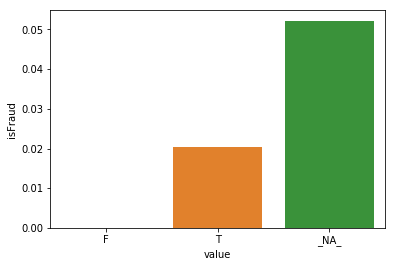

In [21]:
sns.barplot('value','isFraud',data=df3)

## plot categoricals by value and effect on isFraud

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


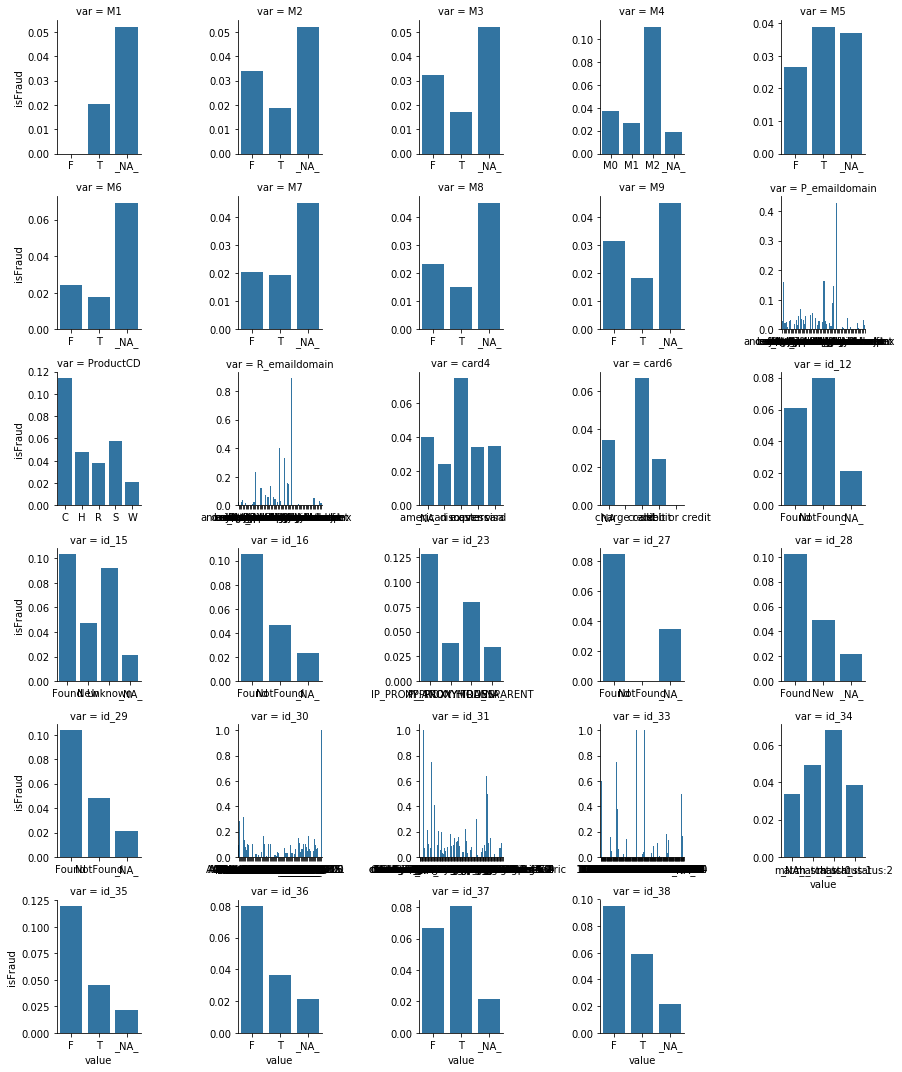

In [22]:
g = sns.FacetGrid(df2, col="var", col_wrap=5, height=2.5, sharex=False, sharey=False)
g = g.map(sns.barplot,'value','isFraud')

## get smaller sample for each categorical to do chi-square analysis

In [23]:
df4 = df.groupby('var', group_keys=False).apply(lambda x: x.sample(n=min(10000,x.shape[0]), random_state=13))
df4.head()
df4.sample()

,isFraud,value,var
252434,0,F,M2


In [24]:
df4.groupby(['var','value'])['isFraud'].mean().head(10)

var  value
M1   T        0.019040
     _NA_     0.051179
M2   F        0.037106
     T        0.016974
     _NA_     0.051179
M3   F        0.028777
     T        0.016425
     _NA_     0.051179
M4   M0       0.039545
     M1       0.024138
Name: isFraud, dtype: float64

In [25]:
df5 = df4.loc[df4['var'] =='M2']
print(df5.shape)
df5.head()

(10000, 3)


,isFraud,value,var
178744,0,T,M2
510664,0,_NA_,M2
12800,0,T,M2
559656,0,T,M2
317812,0,_NA_,M2


In [26]:
pd.crosstab(df5.isFraud, df5.value)

value,F,T,_NA_
isFraud,,,
0,519,4633,4505
1,20,80,243


In [27]:
simulate_chi_square(pd.crosstab(df5.isFraud, df5.value).values)

(83.67971934771144, 0.0, array([[ 520.5123, 4551.3441, 4585.1436],
        [  18.4877,  161.6559,  162.8564]]))

In [28]:
chisq = df4.groupby('var')\
            .apply(lambda x: simulate_chi_square(pd.crosstab(x.isFraud,x.value).values, trials=1000))\
            .apply(lambda x: {'chi_sq':x[0], 'p_value': x[1]})

In [29]:
chisq_df = pd.DataFrame(chisq.to_list(), index=chisq.index)

In [43]:
chisq_df.sort_values('p_value', ascending=False)

,chi_sq,p_value
var,,
id_30,51.075380,0.620
id_34,1.326886,0.590
P_emaildomain,75.931155,0.164
id_27,1.556524,0.134
id_33,101.667279,0.108
M5,4.960002,0.075
id_23,7.734288,0.071
card4,22.472885,0.001
M1,77.761730,0.000


In [52]:
chisq = df4.groupby('var')\
            .apply(lambda x: stats.chi2_contingency(pd.crosstab(x.isFraud,x.value).values))\
            .apply(lambda x: {'chi_sq':x[0], 'p_value': x[1]})

In [40]:
tmpdir = tempfile.mkdtemp()

In [42]:
tmpdir

'/tmp/tmpk2_tpc72'

In [53]:
%%capture --no-stderr cap

print(chisq2_df.sort_values('p_value', ascending=False))

with open(os.path.join(tmpdir,'full_chisq_analysis.txt'), 'w') as f:
    f.write(cap.stdout)

In [54]:
mlflow.get_tracking_uri()

'/opt/project/tracking'

In [55]:
0.05/34

0.0014705882352941176

In [58]:
%%capture --no-stderr cap

print(chisq2_df.loc[chisq2_df['p_value'] < (0.05/34)])

with open(os.path.join(tmpdir,'significant_chisq_analysis.txt'), 'w') as f:
    f.write(cap.stdout)

In [60]:
# save sample as mlflow artifact
experiment_id = mlflow.set_experiment('eda')

#%%
with mlflow.start_run(experiment_id=experiment_id, run_name='cat_var_analysis'):
    mlflow.log_param('notebook_name',notebookName)
    mlflow.log_artifact(os.path.join(tmpdir,'full_chisq_analysis.txt'))
    mlflow.log_artifact(os.path.join(tmpdir,'significant_chisq_analysis.txt'))

#%%
# clean up temp directory
shutil.rmtree(tmpdir)